# Wearable Stress & Academic Performance Analysis

This notebook explores whether physiological stress signals collected from wearable devices
can predict academic performance during exams.

Dataset: Wearable Exam Stress Dataset  
Target: Exam grade  
Model: Linear regression with cross-validation

## 1. Dataset Overview

This section explores the structure of the wearable stress dataset and the accompanying
student grade records. The raw grades file is unstructured and requires custom parsing to extract exam scores.

In [25]:
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Signal processing
from scipy.signal import find_peaks

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

# Base data path
BASE_DATA_PATH = "../data/raw"

# Load raw grades file
grades_raw = pd.read_csv(
    os.path.join(BASE_DATA_PATH, "StudentGrades.txt"),
    encoding="latin1",
    header=None,
    engine="python",
    on_bad_lines="skip"
).fillna("")

# Detect exam sections and extract grades
records = []
current_exam = None

for _, row in grades_raw.iterrows():
    row_str = " ".join(row.astype(str))
    
    # Update current exam section
    if "MIDTERM 1" in row_str: # M1 is out of 100 marks
        current_exam = 1
    elif "MIDTERM 2" in row_str: # M2 is out of 100 marks
        current_exam = 2
    elif "FINAL" in row_str: # Final is out of 200 marks
        current_exam = 3
    
    # Extract student grades
    elif current_exam and row_str.strip().startswith("S"):
        parts = row_str.split()
        student_id = next((p for p in parts if p.startswith("S")), None)
        grade_val = next((int(p) for p in parts if p.isdigit()), None)
        
        if student_id and grade_val:
            records.append({
                "student": student_id.replace("S0", "S"),
                "grade": grade_val,
                "exam": current_exam
            })

grades = pd.DataFrame(records)

grades.head()

,student,grade,exam
0,S1,78,1
1,S2,82,1
2,S3,77,1
3,S4,75,1
4,S5,67,1


## 2. Feature Engineering from EDA Signals

Electrodermal activity (EDA) signals are transformed into interpretable
summary features capturing baseline stress, variability, and acute stress responses.

In [19]:
# Explore wearable data structure

WEARABLE_PATH = "../data/raw/Data"

participants = sorted(os.listdir(WEARABLE_PATH))

print("Participants:", participants)

# Inspect one participant (Check)
sample_participant = participants[0]
sample_path = os.path.join(WEARABLE_PATH, sample_participant)

print(f"\n{sample_participant} contains:")
print(os.listdir(sample_path))

# Inspect one exam folder (Check)
sample_exam = os.listdir(sample_path)[0]
exam_path = os.path.join(sample_path, sample_exam)

print(f"\n{sample_participant}/{sample_exam} contains:")
print(os.listdir(exam_path))

Participants: ['S1', 'S10', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']

S1 contains:
['Final', 'Midterm 1', 'Midterm 2']

S1/Final contains:
['ACC.csv', 'BVP.csv', 'EDA.csv', 'HR.csv', 'IBI.csv', 'info.txt', 'tags.csv', 'TEMP.csv']


In [20]:
def extract_eda_features(eda_series):
    """
    Extract stress features from EDA signal
    """
    eda = eda_series.values.astype(float)
    
    features = {}
    
    # Basic statistics
    features["eda_mean"] = np.mean(eda)
    features["eda_std"] = np.std(eda)
    features["eda_p95"] = np.percentile(eda, 95)
    
    # Stress peaks
    peaks, _ = find_peaks(eda, height=0.1, distance=50)
    features["eda_peak_count"] = len(peaks)
    
    # Stress trend (the slope)
    x = np.arange(len(eda))
    slope = np.polyfit(x, eda, 1)[0]
    features["eda_trend"] = slope
    
    return features


# Extract all EDA features using function
eda_features = []

for student in sorted(os.listdir(WEARABLE_PATH)):
    student_path = os.path.join(WEARABLE_PATH, student)
    
    for exam_folder in os.listdir(student_path):
        exam_path = os.path.join(student_path, exam_folder)
        
        eda_file = os.path.join(exam_path, "EDA.csv")
        
        if not os.path.exists(eda_file):
            continue
        
        eda_df = pd.read_csv(eda_file)
        eda_series = eda_df.iloc[:, 0]
        
        features = extract_eda_features(eda_series)
        features["student"] = student
        features["exam"] = exam_folder
        
        eda_features.append(features)

eda_features_df = pd.DataFrame(eda_features)

eda_features_df.head()

,eda_mean,eda_std,eda_p95,eda_peak_count,eda_trend,student,exam
0,0.102966,0.084358,0.215264,667,-1.925187e-06,S1,Final
1,0.325991,0.520383,1.748356,392,-2.172022e-06,S1,Midterm 1
2,0.116675,0.097575,0.212701,352,-5.407527e-07,S1,Midterm 2
3,0.111137,0.152480,0.244986,679,-2.084109e-06,S10,Final
4,0.201648,0.167342,0.380822,397,3.469520e-06,S10,Midterm 1


## 3. Modeling Dataset Construction

Physiological features are aligned with exam outcomes at the
(student, exam) level.

In [21]:
# Prepare grades for merge
grades_clean = grades.copy()

# Map exam numbers to names
exam_map = {
    1: "Midterm 1",
    2: "Midterm 2",
    3: "Final"
}

grades_clean["exam"] = grades_clean["exam"].map(exam_map)

# Ensure consistent types
grades_clean["student"] = grades_clean["student"].astype(str)

# Merge EDA features with grades
ml_df = eda_features_df.merge(
    grades_clean,
    on=["student", "exam"],
    how="inner"
)

ml_df.head()

,eda_mean,eda_std,eda_p95,eda_peak_count,eda_trend,student,exam,grade
0,0.102966,0.084358,0.215264,667,-1.925187e-06,S1,Final,182
1,0.325991,0.520383,1.748356,392,-2.172022e-06,S1,Midterm 1,78
2,0.116675,0.097575,0.212701,352,-5.407527e-07,S1,Midterm 2,82
3,0.111137,0.152480,0.244986,679,-2.084109e-06,S10,Final,116
4,0.201648,0.167342,0.380822,397,3.469520e-06,S10,Midterm 1,89


## 4. Stress–Performance Modeling

A linear regression model is trained using standardized features and evaluated
using leave-one-out cross-validation with RMSE.

In [22]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

# Feature columns
FEATURE_COLS = [
    "eda_mean",
    "eda_std",
    "eda_p95",
    "eda_peak_count",
    "eda_trend"
]

X = ml_df[FEATURE_COLS]
y = ml_df["grade"]

X.shape, y.shape

((30, 5), (30,))

In [23]:
# LOOCV with RMSE (LOOCV is where the model is trained on 29 samples and tested on the remaining one, repeated for every data point)
loo = LeaveOneOut()

neg_mse_scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=loo,
    scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-neg_mse_scores)

print(f"Mean RMSE (LOOCV): {rmse_scores.mean():.2f}")
print(f"Std RMSE: {rmse_scores.std():.2f}")

Mean RMSE (LOOCV): 21.46
Std RMSE: 14.35


## 5. Model Interpretation

Model coefficients are analyzed to understand which stress patterns
are associated with higher or lower academic performance.

In [24]:
# Interpret model coefficients
pipeline.fit(X, y)

coef_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "coefficient": pipeline.named_steps["regressor"].coef_
}).sort_values(
    by="coefficient",
    key=abs,
    ascending=False
)

coef_df

,feature,coefficient
3,eda_peak_count,41.047732
0,eda_mean,-10.622143
2,eda_p95,5.181019
4,eda_trend,4.146152
1,eda_std,-0.275442


## Relationship Between Acute Stress and Exam Performance

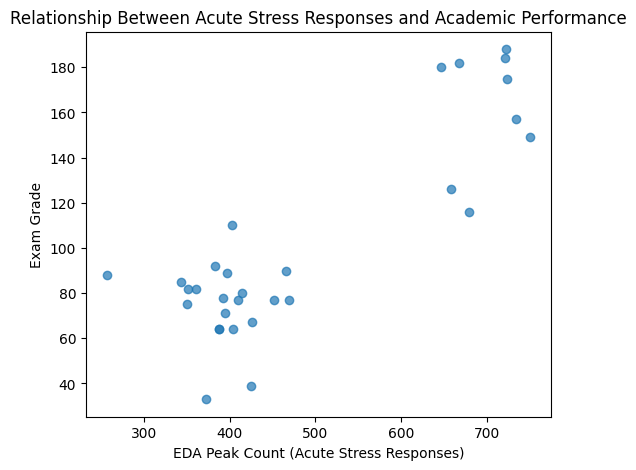

In [27]:
# Scatter plot: EDA peak count vs exam grade
plt.figure(figsize=(6, 5))

plt.scatter(
    ml_df["eda_peak_count"],
    ml_df["grade"],
    alpha=0.7
)

plt.xlabel("EDA Peak Count (Acute Stress Responses)")
plt.ylabel("Exam Grade")
plt.title("Relationship Between Acute Stress Responses and Academic Performance")

plt.show()

**Interpretation of results:**  
The visualization suggests that the number of short-term electrodermal activity (EDA) peaks, which reflect moments of physiological stress, is related to exam performance in a non-random way. Although the data is noisy and does not imply causation, students with more frequent stress responses show a wide range of outcomes, indicating that stress may interact with performance in a complex way. This motivates further modeling to better understand how stress patterns relate to academic results. Using leave-one-out cross-validation, the model achieved an average prediction error of about 21 points, which is reasonable given the small dataset and not wanting to overfit the data.
